In [3]:
import json, os

### Upload datasets from private API (remove)

In [4]:
# AIXÒ FER-HO PRIVAT , de moment esta aixi per estalviar uploadear els datasets cada cop

data = {
    "username":"albertroca29",
    "key":"abb86cea6e8b29e5a3002793d9210162"
}
with open("kaggle.json", "w") as f:
    json.dump(data, f)

os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d albertroca29/arlsgqrms/UH_2023_TRAIN.txt

 61% 25.0M/40.8M [00:00<00:00, 73.4MB/s]
100% 40.8M/40.8M [00:00<00:00, 91.3MB/s]


### Unzip the zip file to have the datasets 

In [5]:
!unzip \*.zip  && rm *.zip

Archive:  arlsgqrms.zip
  inflating: DATOS_ETO.TXT           
  inflating: DATOS_METEO.TXT         
  inflating: UH_2023_TRAIN.txt       


Pandas dataset

In [6]:
import pandas as pd

def load_dataset(path): 
    dataset = pd.read_csv(path, header=0, delimiter='|')
    return dataset

train = load_dataset('UH_2023_TRAIN.txt')
meteo = load_dataset('DATOS_METEO.TXT')
eto = load_dataset('DATOS_ETO.TXT')

df = {'train':train,'meteo':meteo,'eto':eto}

Dimensions

In [7]:
_=[print(nom,'\t',dataset.shape) for nom,dataset in df.items()]

train 	 (9601, 11)
meteo 	 (1223660, 33)
eto 	 (51180, 275)


In [8]:
_=[print(nom,'\t',dataset.columns) for nom,dataset in df.items()]

train 	 Index(['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION', 'ALTITUD', 'VARIEDAD',
       'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION'],
      dtype='object')
meteo 	 Index(['validTimeUtc', 'precip1Hour', 'precip6Hour', 'precip24Hour',
       'precip2Day', 'precip3Day', 'precip7Day', 'precipMtd', 'precipYtd',
       'pressureChange', 'pressureMeanSeaLevel', 'relativeHumidity',
       'snow1Hour', 'snow6Hour', 'snow24Hour', 'snow2Day', 'snow3Day',
       'snow7Day', 'snowMtd', 'snowSeason', 'snowYtd', 'temperature',
       'temperatureChange24Hour', 'temperatureMax24Hour',
       'temperatureMin24Hour', 'temperatureDewPoint', 'temperatureFeelsLike',
       'uvIndex', 'visibility', 'windDirection', 'windGust', 'windSpeed',
       'ID_ESTACION'],
      dtype='object')
eto 	 Index(['date', 'DewpointLocalAfternoonAvg', 'DewpointLocalAfternoonMax',
       'DewpointLocalAfternoonMin', 'DewpointLocalDayAvg',
       'DewpointLocalDayMax', 'DewpointLocalDayMin', 'DewpointLocalDaytimeA

NaNs en train

In [9]:
train.isnull().sum()

CAMPAÑA           0
ID_FINCA          0
ID_ZONA           0
ID_ESTACION       0
ALTITUD          54
VARIEDAD          0
MODO              0
TIPO              0
COLOR             0
SUPERFICIE        0
PRODUCCION     1075
dtype: int64

### Relacio entre dades no meteo

In [10]:
train.isnull().sum()
t2 = train[~train.ALTITUD.isnull()]
t2 = t2[~t2.PRODUCCION.isnull()]
print(t2.isnull().sum())

CAMPAÑA        0
ID_FINCA       0
ID_ZONA        0
ID_ESTACION    0
ALTITUD        0
VARIEDAD       0
MODO           0
TIPO           0
COLOR          0
SUPERFICIE     0
PRODUCCION     0
dtype: int64


In [11]:
train.dtypes

CAMPAÑA          int64
ID_FINCA         int64
ID_ZONA          int64
ID_ESTACION      int64
ALTITUD         object
VARIEDAD         int64
MODO             int64
TIPO             int64
COLOR            int64
SUPERFICIE     float64
PRODUCCION     float64
dtype: object

In [12]:
for i in range(t2.shape[0]):
    valor = t2['ALTITUD'].values[i]
    if(len(valor)>3):
        t2['ALTITUD'].values[i] = int((int(valor[:3])+int(valor[-3:]))/2)
    else:
        t2['ALTITUD'].values[i] = int(valor)

t2['ALTITUD'] = pd.to_numeric(t2['ALTITUD'])

<AxesSubplot:>

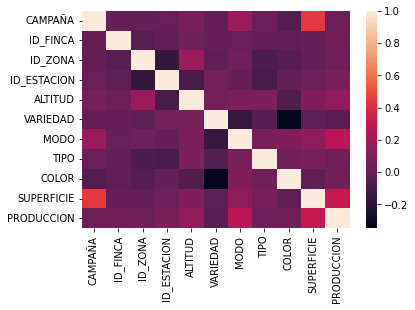

In [13]:
import seaborn as sns

sns.heatmap(t2.corr())

In [160]:
# PRIMERA PREDICCIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,ElasticNet,ElasticNetCV
import time
from sklearn.metrics import mean_squared_error as MSE
import math
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier as RFC

X_columns = t2.drop('PRODUCCION',axis=1).columns
X = t2.drop('PRODUCCION',axis=1).values
y = t2.PRODUCCION.values

# norm
mm = make_pipeline(StandardScaler(), MinMaxScaler())

X_norm = mm.fit_transform(X)
# y_norm = mm.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_norm ,y , test_size=0.25)

t = time.time()

# # Defining the hyper parameters 
# hps = {
#     'max_depth': 3,
#     'min_samples_split': 4,
#     'random_state': 0
# }

models = {
    'RidgeCV':RidgeCV(),
    'SVR':SVR(),
    'DTR':DTR()
    # 'RFC':RFC()
}
for nom,m in models.items():
    m.fit(X_train, y_train)

    # Make predictions for some new data
    y_pred = m.predict(X_test)

    # Measure the mean squared error of the predictions
    mse = MSE(y_test, y_pred)
    print(nom,'RMSE= ',math.sqrt(mse))
    print('the mean of productoin', np.mean(y))
    print("temps = %3.4fs"%(time.time()-t))

    print(y_test,y_pred)


RidgeCV RMSE=  11943.16009433162
the mean of productoin 9198.515518862807
temps = 0.0085s
[ 4530.99   9130.416 20105.8   ...  2950.     3706.315  3604.56 ] [12496.63056515 11152.09524282 15550.78257766 ...  9489.03480746
 10445.92205304  8892.43832964]
SVR RMSE=  14045.1888794288
the mean of productoin 9198.515518862807
temps = 2.6294s
[ 4530.99   9130.416 20105.8   ...  2950.     3706.315  3604.56 ] [4968.06332569 4934.58639631 4955.44533357 ... 4508.71867771 4946.27668902
 4932.00293656]
DTR RMSE=  8241.871361149862
the mean of productoin 9198.515518862807
temps = 2.6629s
[ 4530.99   9130.416 20105.8   ...  2950.     3706.315  3604.56 ] [ 3772.431  2928.272 29274.    ...  2880.     2343.864  2953.2  ]


PLOT COEFFICIENTS (per model lineal)

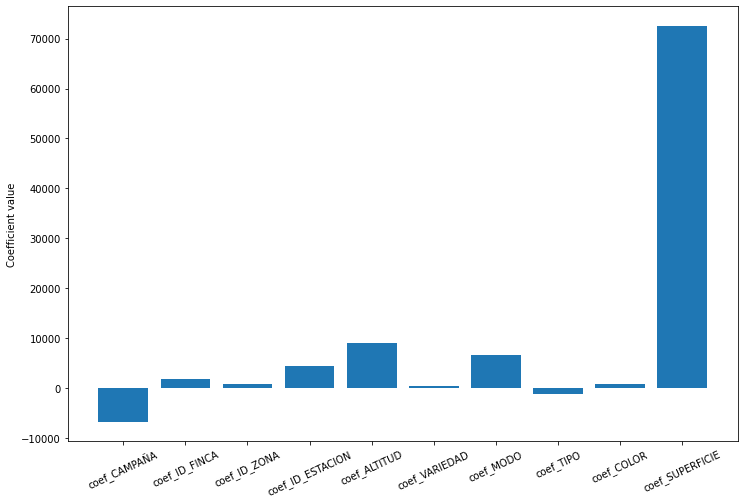

In [161]:
coef_names = [f'coef_{X_columns[i]}' for i in range(X_norm.shape[1])]
plt.figure(figsize=(12,8))
plt.bar(coef_names, models['RidgeCV'].coef_)
plt.xticks(rotation=25)
plt.ylabel('Coefficient value')
plt.show()


Feature importance RandomForest

Feature importance: {'CAMPAÑA': 0.10539, 'ID_FINCA': 0.24583, 'ID_ZONA': 0.09283, 'ID_ESTACION': 0.0443, 'ALTITUD': 0.11935, 'VARIEDAD': 0.1829, 'MODO': 0.05862, 'TIPO': 0.00163, 'COLOR': 0.00844, 'SUPERFICIE': 0.1407}


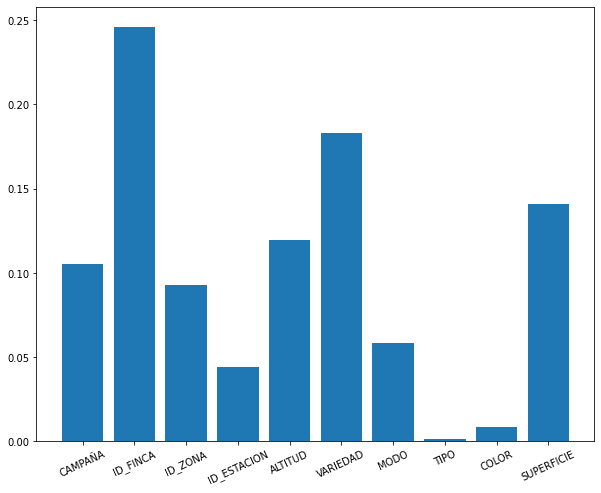

In [162]:

# Extracting the importances by sklearn 
importances_dtr = models['DTR'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_dtr = {}
for i, feature in enumerate(X_columns):
    feature_importance_dtr[feature] = round(importances_dtr[i], 5)

plt.figure(figsize=(10,8))
print(f"Feature importance: {feature_importance_dtr}")
plt.bar(feature_importance_dtr.keys(), feature_importance_dtr.values())
plt.xticks(rotation=25)
plt.show()

In [114]:
# now same regression but only with 0,3,4,6,9
model = RidgeCV()
L = [0,1,2,3,4,5,6,7,8,9]
model.fit(X_train[:,L], y_train)

# Make predictions for some new data
y_pred = model.predict(X_test[:,L])

# Measure the mean squared error of the predictions
mse = MSE(y_test, y_pred)
print('RMSE= ',math.sqrt(mse))
print('the mean of productoin', np.mean(y))
print("temps = %3.4fs"%(time.time()-t))

print(y_test,y_pred)

RMSE=  11500.343304531345
the mean of productoin 9198.515518862807
temps = 53.5279s
[10166.14  7970.   32086.14 ...  7508.    3396.   16220.  ] [22378.38264935  6281.90249472 32876.48126461 ...  9743.86532635
  7447.04422777  6978.19960962]


PCA

In [68]:
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X_norm)

# View the principal components
print(pca.components_)

[[-1.74880711e-01 -8.53484578e-03 -2.09020470e-02 -3.05713898e-03
  -2.63815728e-02  1.23882243e-01 -9.64982140e-01 -1.72697894e-02
  -1.44644867e-01 -2.10699105e-02]
 [ 2.82836103e-01  2.59598520e-02  6.07226168e-02  8.83103536e-03
   5.82740274e-02  3.61101901e-01  1.22823172e-01 -9.88191640e-03
  -8.75269823e-01  2.22195858e-02]
 [-9.38545456e-01  5.65260662e-03  4.59603105e-02 -3.59623685e-02
  -2.18757730e-03  8.69894715e-02  2.17394088e-01 -4.53115249e-03
  -2.35825371e-01 -7.23087354e-02]
 [-1.27278145e-02  9.55040651e-01 -2.75477566e-01  1.00780968e-01
  -2.43987101e-02  2.85693635e-02  1.33077231e-03  2.69061770e-03
   1.64362075e-02 -2.22877200e-05]
 [ 3.28369875e-02  2.81708765e-01  7.36955672e-01 -5.73284633e-01
   1.59456935e-01 -1.41750168e-01 -4.66913551e-02  1.94443474e-03
   9.90145137e-03  1.20211056e-03]]


In [15]:
eto.head()

,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
0,20150629,285.9,285.9,285.9,286.0,287.0,285.4,285.9,285.9,285.9,...,NaN,NaN,NaN,2.6,5.0,1.1,1.7,2.1,1.1,13
1,20150630,283.0,283.6,282.5,284.3,286.5,282.5,283.2,283.9,282.5,...,2.2,3.8,1.4,2.7,5.2,1.4,1.5,1.9,1.4,13
2,20150701,286.1,286.5,285.5,285.8,288.0,283.8,285.4,286.5,283.8,...,2.7,4.3,1.2,3.0,5.7,1.4,1.9,2.8,1.4,13
3,20150702,288.9,289.4,287.9,288.3,291.8,286.1,287.7,289.4,286.1,...,1.7,2.3,1.2,3.6,5.4,2.4,2.7,3.4,2.4,13
4,20150703,289.1,290.4,288.5,290.5,293.0,287.8,290.6,293.0,288.5,...,3.5,5.0,2.3,3.1,6.0,1.5,1.9,2.2,1.5,13


A partir d'aqui nomes treballarem amb les bases de dades eto i train, deixan la de meteo de banda.

### REPERTICIO PER ANY (no te sentit, es nomes per familiaritzar-se amb l'entorn)

Afegint tots els atributs de eto, passats de dia a **any**

In [16]:
eto['CAMPAÑA'] =eto['date']/10000-2000
eto['CAMPAÑA'] = eto['CAMPAÑA'].astype(int)

In [17]:
means = eto.groupby(['CAMPAÑA','ID_ESTACION']).mean()

In [18]:
means.head()

date  DewpointLocalAfternoonAvg  \
CAMPAÑA ID_ESTACION                                            
15      0            2.015096e+07                 286.166667   
        1            2.015096e+07                 284.720430   
        2            2.015096e+07                 286.197312   
        3            2.015096e+07                 285.709677   
        4            2.015096e+07                 285.232258   

                     DewpointLocalAfternoonMax  DewpointLocalAfternoonMin  \
CAMPAÑA ID_ESTACION                                                         
15      0                           286.903226                 285.500000   
        1                           285.510753                 284.037634   
        2                           286.885484                 285.580108   
        3                           286.553763                 285.064516   
        4                           285.936022                 284.604301   

                     DewpointLocalDayAvg  DewpointLocalDayMax  \
CAMPAÑA ID_ESTACION                                             
15      0                     286.118280           288.252688   
        1                     284.849462           287.107527   
        2                     285.874194           288.171505   
        3                     285.801075           288.086022   
        4                     285.282258           287.469355   

                     DewpointLocalDayMin  DewpointLocalDaytimeAvg  \
CAMPAÑA ID_ESTACION                                                 
15      0                     283.779570               285.983871   
        1                     282.408602               284.704301   
        2                     283.309677               285.859677   
        3                     283.408602               285.655914   
        4                     282.898925               285.151613   

                     DewpointLocalDaytimeMax  DewpointLocalDaytimeMin  ...  \
CAMPAÑA ID_ESTACION                                                    ...   
15      0                         287.451613               284.139785  ...   
        1                         286.311828               282.768817  ...   
        2                         287.469892               283.634946  ...   
        3                         287.215054               283.752688  ...   
        4                         286.654839               283.257527  ...   

                     WindSpeedLocalEveningMin  WindSpeedLocalMorningAvg  \
CAMPAÑA ID_ESTACION                                                       
15      0                            1.716129                  1.932432   
        1                            1.860215                  1.974054   
        2                            1.780108                  1.877838   
        3                            1.833871                  1.969730   
        4                            1.905376                  1.925946   

                     WindSpeedLocalMorningMax  WindSpeedLocalMorningMin  \
CAMPAÑA ID_ESTACION                                                       
15      0                            2.629730                  1.367568   
        1                            2.673514                  1.370811   
        2                            2.536216                  1.360000   
        3                            2.652432                  1.397838   
        4                            2.603243                  1.365946   

                     WindSpeedLocalNighttimeAvg  WindSpeedLocalNighttimeMax  \
CAMPAÑA ID_ESTACION                                                           
15      0                              2.105376                    3.346774   
        1                              2.254301                    3.522043   
        2                              2.120430                    3.306989   
        3                              2.223656                    3.470968   
        4                  

In [19]:
t3 = t2.copy()
t3 = t3.merge(means,on=['CAMPAÑA','ID_ESTACION'])

<AxesSubplot:>

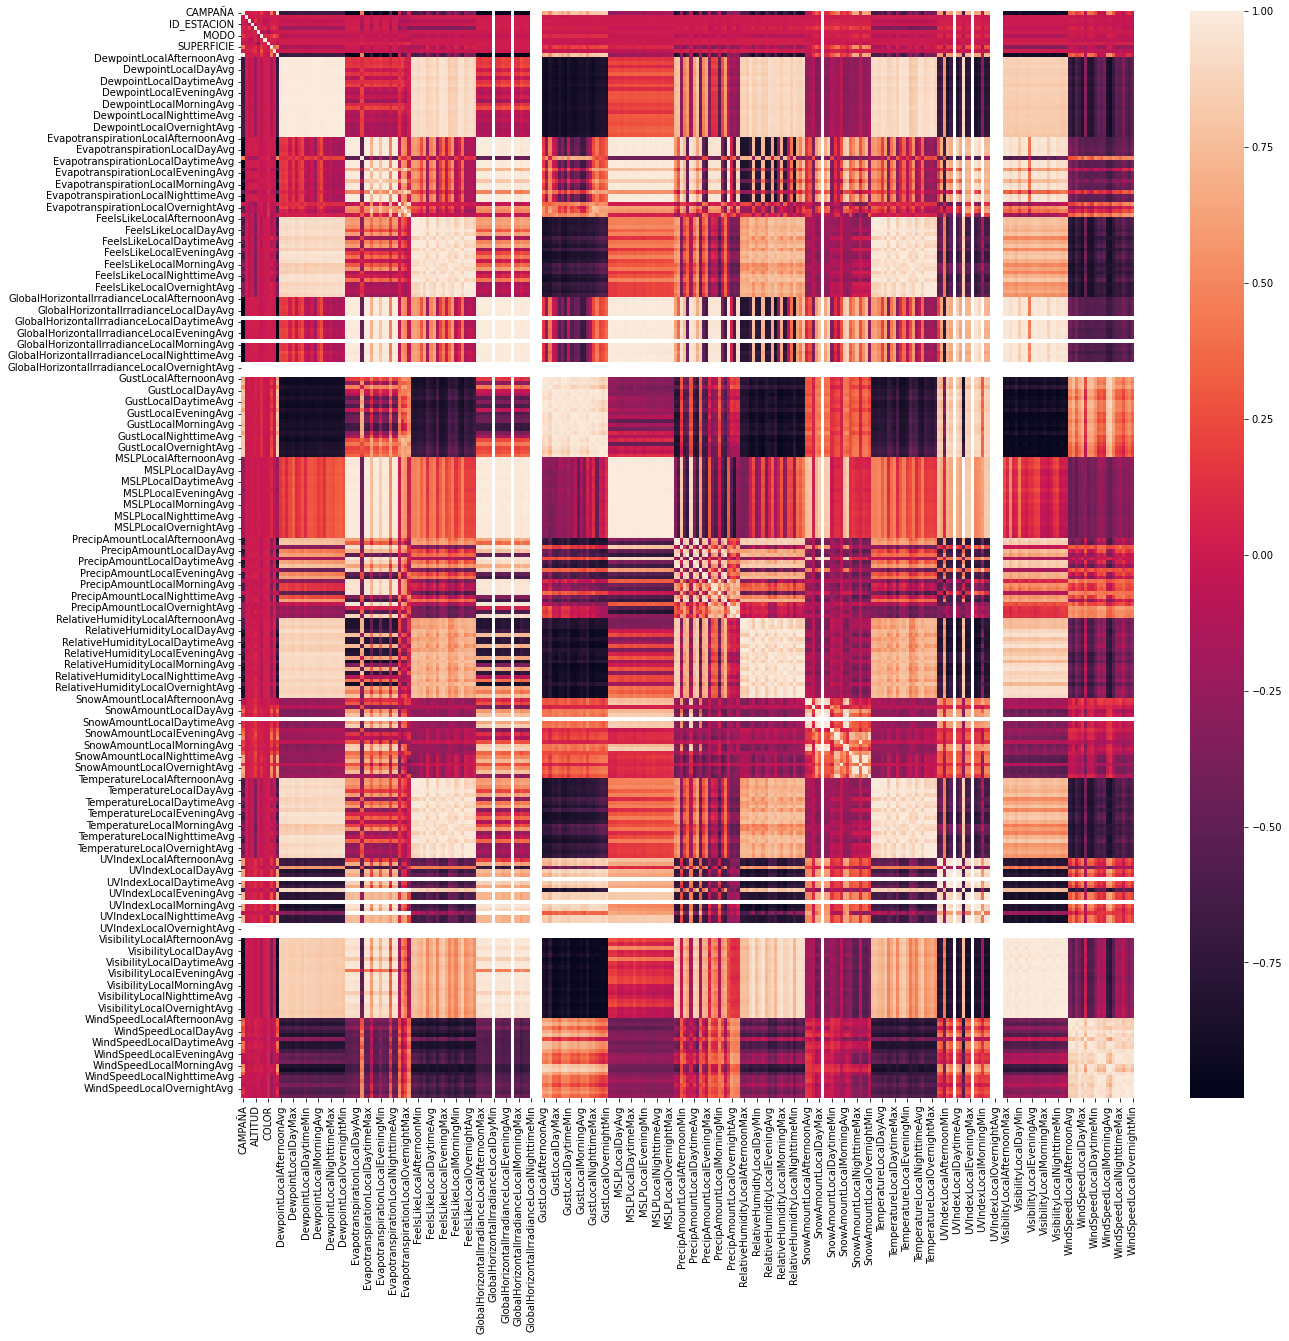

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(t3.corr())

In [21]:
t3.describe()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,...,WindSpeedLocalEveningMin,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin
count,7338.000000,7338.000000,7338.00000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,...,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000,7338.000000
mean,17.955983,50751.208504,499.11202,12.191605,578.994004,45.515263,1.509131,0.013900,0.844917,0.597847,...,2.003770,2.656004,3.550781,1.879903,2.480556,3.827079,1.592944,2.193193,2.638228,1.757879
std,2.010494,29022.764870,260.99404,4.775919,76.102061,23.712210,0.499951,0.117085,0.362009,1.678556,...,0.195801,0.363904,0.445004,0.288137,0.240025,0.310398,0.189376,0.245899,0.281420,0.216229
min,15.000000,200.000000,7.00000,1.000000,370.000000,4.000000,1.000000,0.000000,0.000000,0.000000,...,1.344536,1.877838,2.536216,1.299454,1.896175,3.101366,1.017213,1.559016,1.945355,1.178689
25%,16.000000,25026.000000,284.00000,7.000000,490.000000,17.000000,1.000000,0.000000,1.000000,0.000000,...,1.833871,2.551913,3.485519,1.729863,2.254918,3.554098,1.424194,1.986301,2.432603,1.583880
50%,18.000000,50799.000000,464.00000,12.000000,610.000000,52.000000,2.000000,0.000000,1.000000,0.000000,...,2.002740,2.683836,3.626301,1.933699,2.487397,3.850959,1.594247,2.207397,2.678630,1.753973
75%,20.000000,76350.500000,726.00000,16.000000,635.000000,59.000000,2.000000,0.000000,1.000000,0.289860,...,2.170765,2.889315,3.859178,2.054577,2.673497,4.082240,1.750411,2.343989,2.818630,1.935246
max,21.000000,99693.000000,990.00000,19.000000,820.000000,94.000000,2.000000,1.000000,1.000000,26.850000,...,2.550411,3.390411,4.430137,2.541096,3.120548,4.635068,2.054247,2.804384,3.316986,2.307945


In [22]:
t3 = t3.fillna(t3.mean())

In [163]:
# PRIMERA PREDICCIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,ElasticNet,ElasticNetCV
import time
from sklearn.metrics import mean_squared_error as MSE
import math
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier as RFC

X_columns = t3.drop('PRODUCCION',axis=1).columns
X = t3.drop('PRODUCCION',axis=1).values
y = t3.PRODUCCION.values

# norm
mm = make_pipeline(StandardScaler(), MinMaxScaler())

X_norm = mm.fit_transform(X)
# y_norm = mm.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_norm ,y , test_size=0.25)

t = time.time()

# # Defining the hyper parameters 
# hps = {
#     'max_depth': 3,
#     'min_samples_split': 4,
#     'random_state': 0
# }

models = {
    'RidgeCV':RidgeCV(),
    'SVR':SVR(),
    'DTR':DTR()
    # 'RFC':RFC()
}
for nom,m in models.items():
    m.fit(X_train, y_train)

    # Make predictions for some new data
    y_pred = m.predict(X_test)

    # Measure the mean squared error of the predictions
    mse = MSE(y_test, y_pred)
    print(nom,'RMSE= ',math.sqrt(mse))
    print('the mean of productoin', np.mean(y))
    print("temps = %3.4fs"%(time.time()-t))

    print(y_test,y_pred)


RidgeCV RMSE=  11950.840093111949
the mean of productoin 9391.740863777597
temps = 0.1714s
[6986.524  510.    5030.    ... 9978.001 7620.    2559.776] [ 6981.54017773  2631.57955618 11297.39463574 ... 10300.98298964
 11503.52904827  8047.54860005]
SVR RMSE=  14228.448042851376
the mean of productoin 9391.740863777597
temps = 6.3930s
[6986.524  510.    5030.    ... 9978.001 7620.    2559.776] [4716.56600462 4733.23380977 4748.31056339 ... 4766.6252254  4779.20453981
 4728.45001653]
DTR RMSE=  13267.278986446527
the mean of productoin 9391.740863777597
temps = 6.8106s
[6986.524  510.    5030.    ... 9978.001 7620.    2559.776] [  4226.216   2292.255  10060.    ... 105820.      4086.3     7370.   ]


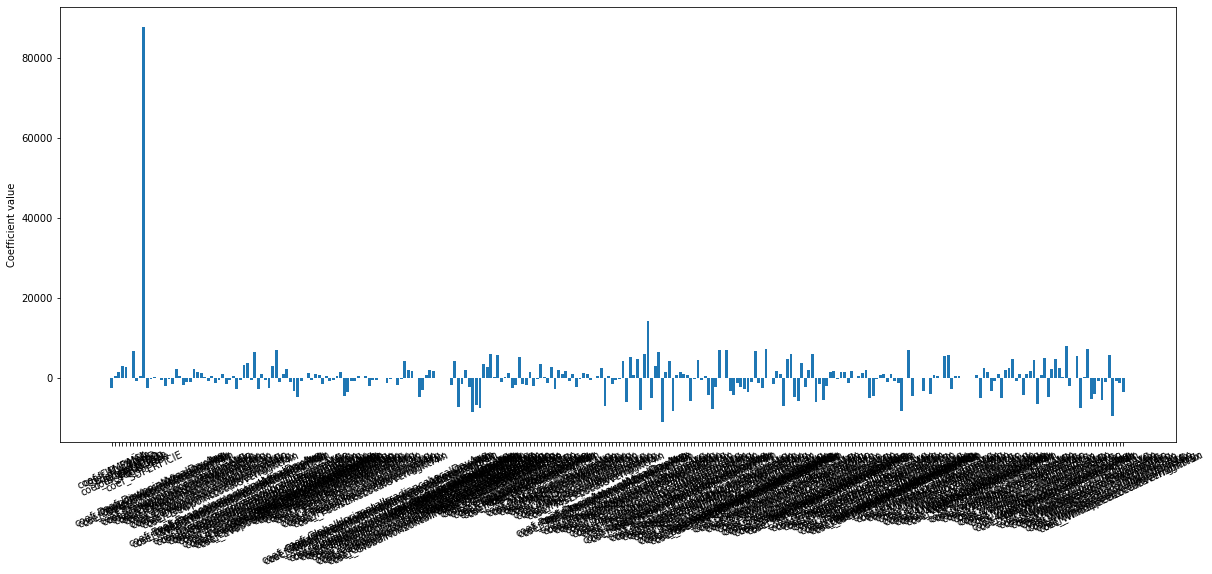

In [166]:
coef_names = [f'coef_{X_columns[i]}' for i in range(X_norm.shape[1])]
plt.figure(figsize=(20,8))
plt.bar(coef_names, models['RidgeCV'].coef_)
plt.xticks(rotation=25)
plt.ylabel('Coefficient value')
plt.show()


Feature importance: {'CAMPAÑA': 0.00049, 'ID_FINCA': 0.22749, 'ID_ZONA': 0.0683, 'ID_ESTACION': 0.0115, 'ALTITUD': 0.09601, 'VARIEDAD': 0.16747, 'MODO': 0.06659, 'TIPO': 0.00136, 'COLOR': 0.01159, 'SUPERFICIE': 0.15949, 'date': 0.00025, 'DewpointLocalAfternoonAvg': 0.00084, 'DewpointLocalAfternoonMax': 0.00108, 'DewpointLocalAfternoonMin': 1e-05, 'DewpointLocalDayAvg': 2e-05, 'DewpointLocalDayMax': 0.00296, 'DewpointLocalDayMin': 1e-05, 'DewpointLocalDaytimeAvg': 2e-05, 'DewpointLocalDaytimeMax': 9e-05, 'DewpointLocalDaytimeMin': 1e-05, 'DewpointLocalEveningAvg': 2e-05, 'DewpointLocalEveningMax': 7e-05, 'DewpointLocalEveningMin': 0.00077, 'DewpointLocalMorningAvg': 0.00024, 'DewpointLocalMorningMax': 0.00312, 'DewpointLocalMorningMin': 0.00015, 'DewpointLocalNighttimeAvg': 4e-05, 'DewpointLocalNighttimeMax': 0.00013, 'DewpointLocalNighttimeMin': 4e-05, 'DewpointLocalOvernightAvg': 0.00034, 'DewpointLocalOvernightMax': 0.00014, 'DewpointLocalOvernightMin': 1e-05, 'EvapotranspirationLoca

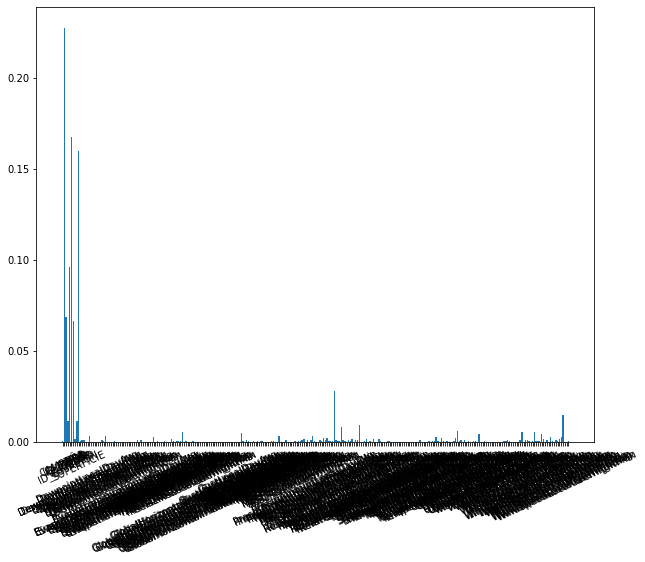

In [165]:
# Extracting the importances by sklearn 
importances_dtr = models['DTR'].feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_dtr = {}
for i, feature in enumerate(X_columns):
    feature_importance_dtr[feature] = round(importances_dtr[i], 5)

plt.figure(figsize=(10,8))
print(f"Feature importance: {feature_importance_dtr}")
plt.bar(feature_importance_dtr.keys(), feature_importance_dtr.values())
plt.xticks(rotation=25)
plt.show()

In [ ]:
t3.describe()

### REPERTICIO PER ÈPOQUES
<br>
<center><img src=https://raw.githubusercontent.com/AlbertRoca29/The-Wine-Project/main/img/ciclo_vegetativo_vid.jpg width=50%">
</center>
<br>



In [25]:
# èpoques

# Reposo : 

In [26]:
# AFEGIR FECHAS VENDIMIA https://www.riberadelduero.es/consejo-regulador/estadisticas/fechas-de-vendimia

# PODEM FER UN PETIT DATASET O UN SIMPLE DICCIONARI
